In [ ]:
import sys
import os

In [ ]:
!pip install wandb

In [ ]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 999.3 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=74f2dd2b5057300b6311315e19d55a5f5b8e9b3bf56c2162f382c3e4ee59294c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=1a7553b5146905c39d0668a6bdffd2547ab0a4f4d3979db71fb54b3fff6fe9d9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

In [ ]:
!pip install torchinfo


## Required imports

In [ ]:
#required imports

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import segmentation_models_pytorch as smp
from torchvision import transforms
import pandas as pd
import os
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.utils import save_image
import wandb
from tqdm import tqdm
# from torchsummary import summary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


## Unzipping files and loading them

In [ ]:
unzipping and preparing dataset

def unzip_files(file_path, extract_to):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

train_sketch_zip_path = '/content/drive/MyDrive/DL_Assignment-4/Paired_train_sketches.zip'
train_data_zip_path = '/content/drive/MyDrive/DL_Assignment-4/Train_data.zip'
test_sketch_zip_path = '/content/drive/MyDrive/DL_Assignment-4/Paired_test_sketch.zip'
test_data_zip_path = '/content/drive/MyDrive/DL_Assignment-4/Test_data.zip'

unzip_files(train_sketch_zip_path, '/content/drive/MyDrive/DL_Assignment-4')
unzip_files(train_data_zip_path, '/content/drive/MyDrive/DL_Assignment-4')
unzip_files(test_sketch_zip_path, '/content/drive/MyDrive/DL_Assignment-4')
unzip_files(test_data_zip_path, '/content/drive/MyDrive/DL_Assignment-4')

train_labels = pd.read_csv('/kaggle/input/isic-dataset/Train_labels.csv')
train_labels_df = pd.read_csv('/kaggle/input/isic-dataset/Train_labels.csv')
test_labels = pd.read_csv('/kaggle/input/isic-dataset/Test_labels.csv')
class_names = train_labels_df.columns[1:].tolist()


# Building the dataset and dataloader

In [ ]:
def save_temp_images(batch_images, labels, folder_base):
    for img, label_tensor in zip(batch_images, labels):
        label = label_tensor.argmax().item()
        class_folder = f"{folder_base}/{label}"
        os.makedirs(class_folder, exist_ok=True)
        img_path = os.path.join(class_folder, f'img_{label}_{torch.randint(0, 10000, (1,)).item()}.png')
        save_image(img, img_path, normalize=True)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        sketches = data['sketch'].to(device)
        real_images = data['image'].to(device)
        labels = data['label'].to(device)

        generated_images = generator(sketches, labels)

        save_temp_images(real_images.cpu(), labels.cpu(), 'temp_real_images')
        save_temp_images(generated_images.cpu(), labels.cpu(), 'temp_generated_images')

        if i == 0:
            fig, axs = plt.subplots(3, len(sketches), figsize=(15, 10))
            for idx in range(len(sketches)):
                axs[0, idx].imshow(sketches[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, idx].set_title('Sketch')
                axs[0, idx].axis('off')

                axs[1, idx].imshow(generated_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, idx].set_title('Generated Image')
                axs[1, idx].axis('off')

                axs[2, idx].imshow(real_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[2, idx].set_title('Real Image')
                axs[2, idx].axis('off')

            plt.show()


## Dataloader + showing some samples [train only (test later)]

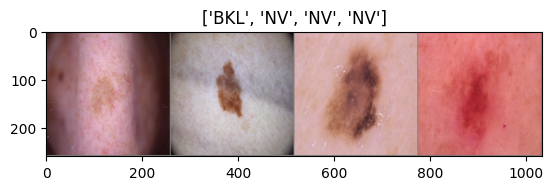

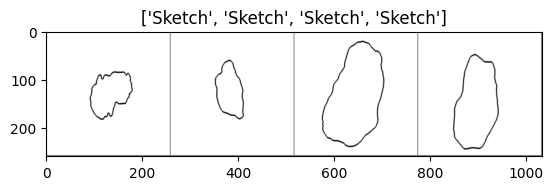

In [ ]:

def imageshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


train_loader = DataLoader(train_dataset, batch_size = 4, shuffle=True)


def one_hot_to_class_name(label_tensor, class_names):
    class_index = label_tensor.numpy().argmax()
    return class_names[class_index]
for i, batch in enumerate(train_loader):
    images = batch['image']
    sketches = batch['sketch']
    labels = batch['label']

    class_names_for_batch = [one_hot_to_class_name(label_tensor, class_names) for label_tensor in labels]

    out = make_grid(images)
    imageshow(out, title=class_names_for_batch)

    out_sketches = make_grid(sketches)
    imageshow(out_sketches, title=["Sketch" for _ in labels])
    break

# Generator Architecture **[FINAL]**

In [ ]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder (ResNet-18)
        model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=4)
        self.encoder = model.encoder

        self.pool = nn.AdaptiveAvgPool2d(1)
        #Flatten()
        self.decoder = nn.Sequential(
            # Begin with the latent vector and one-hot encoded labels
            # UnFlatten(size = 263),
            # [input: latent_dim + 7 x 1 x 1] => [output: ngf*64 x 2 x 2]
            nn.ConvTranspose2d(512+7, 256, kernel_size=4, stride=2, padding= 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(True),

            # Upsampling layers
            # [input: ngf*64 x 2 x 2] => [output: ngf*32 x 4 x 4]
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # [input: ngf*32 x 4 x 4] => [output: ngf*16 x 8 x 8]
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # [input: ngf*16 x 8 x 8] => [output: ngf*8 x 16 x 16]
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            # [input: ngf*8 x 16 x 16] => [output: ngf*4 x 32 x 32]
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),

            # [input: ngf*4 x 32 x 32] => [output: ngf*2 x 64 x 64]
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True),

            # [input: ngf*2 x 64 x 64] => [output: ngf x 128 x 128]
            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2, inplace=True),

            # [input: ngf x 128 x 128] => [output: 3 x 256 x 256]
            nn.ConvTranspose2d(4, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output is image, tanh to get pixel values in [-1, 1]
        )

    def forward(self, x, one_hot_labels):
        batch_size = x.shape[0]
        x = self.encoder(x)
        #print(len(x), x[-1].shape)
        x = self.pool(x[-1])
        #print(f"after average pooling {x.shape}")
        x = x.view(batch_size, -1)
        #print(f"after reshape {x.shape}")
        # Concatenate the one-hot encoded labels to the image vector
        x = torch.cat([x, one_hot_labels], dim=1)
        x = x.view(batch_size, 512+7, 1, 1)
        x = self.decoder(x)
        return x

# generator = Generator().to(device)
# print("Generator Summary:")
# summary(generator, input_size=[(3, 256, 256), (7,)], batch_size=-1, device=str(device))

from torchinfo import summary

generator = Generator().to(device)

batch_size = 1
image_dim = (batch_size, 3, 256, 256)
label_dim = (batch_size, 7)

image_input = torch.randn(image_dim, device=device)
label_input = torch.randn(label_dim, device=device)

print("Generator Summary:")
summary(generator, input_data=[image_input, label_input], depth=3)
#=====================================Example input=================================================



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s] 


Generator Summary:


Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [1, 3, 256, 256]          --
├─ResNetEncoder: 1-1                          [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]          295,42

# Discriminator Architecture **[FINAL]**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_channels, ndf, num_classes, dropout_rate=0.3):
        super(Discriminator, self).__init__()
        self.ndf = ndf

        self.initial = nn.Sequential(
            nn.Conv2d(image_channels, ndf, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.main = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),  # Dropout added here
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),  # Another dropout layer
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(ndf * 8, ndf * 16, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),  # dropout
            nn.Conv2d(ndf * 16, ndf * 32, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate)  # Final dropout layer
        )

        self.flatten = nn.Flatten()

        # Final decision layer
        self.final = nn.Sequential(
            nn.Linear(ndf * 32 * 4 * 4 + num_classes, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img = self.initial(img)
        img = self.main(img)
        img = self.flatten(img)

        combined = torch.cat((img, labels), dim=1)
        output = self.final(combined)
        return output

discriminator = Discriminator(image_channels=3, ndf=32, num_classes=7).to(device)
#===========================Example input=====================================




batch_size = 1
image_dim = (batch_size, 3, 256, 256)
label_dim = (batch_size, 7)

image_input = torch.randn(image_dim, device=device)
label_input = torch.randn(label_dim, device=device)

print("Discriminator Summary:")
summary(discriminator, input_data=[image_input, label_input], depth=3)

Discriminator Summary:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         1,568
│    └─LeakyReLU: 2-2                    [1, 32, 128, 128]         --
├─Sequential: 1-2                        [1, 1024, 4, 4]           --
│    └─Conv2d: 2-3                       [1, 64, 64, 64]           32,832
│    └─BatchNorm2d: 2-4                  [1, 64, 64, 64]           128
│    └─LeakyReLU: 2-5                    [1, 64, 64, 64]           --
│    └─Dropout: 2-6                      [1, 64, 64, 64]           --
│    └─Conv2d: 2-7                       [1, 128, 32, 32]          131,200
│    └─BatchNorm2d: 2-8                  [1, 128, 32, 32]          256
│    └─LeakyReLU: 2-9                    [1, 128, 32, 32]          --
│    └─Dropout: 2-10                     [1, 128, 32, 32]          --
│

## Save images

In [ ]:
import io
from PIL import Image

def save_fig_to_buffer(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    return buf


## WANDB Setup

In [ ]:
wandb_api_key = "cda5ad4d537ea48e73ee63632ace57eb0b75c454"
wandb.login(key=wandb_api_key)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **Final Training Loop**

In [ ]:
from tqdm import tqdm
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torch.nn as nn

# Define optimizers, loss, etc.
import wandb

# if torch.cuda.device_count() > 1:
#     print(f"GPU count : {torch.cuda.device_count()}")
#     generator = nn.DataParallel(generator)
#     discriminator = nn.DataParallel(discriminator)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# generator.to(device)
# discriminator.to(device)

# Initialize wandb
wandb.init(project='DL-Assignment_4', entity='divyaansh')

# Configuring your wandb run
config = wandb.config          # Config is a variable that holds and saves hyperparameters and inputs
config.batch_size = 4 # Assuming batch_size is defined
config.epochs = 50
config.lr = 0.0002
config.betas = (0.5, 0.999)

# Define optimizers, loss, etc.
optimizer_G = optim.Adam(generator.parameters(), lr=config.lr, betas=config.betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=config.lr, betas=config.betas)
criterion_G = nn.BCELoss()
criterion_D = nn.BCELoss()
criterion_mse = nn.MSELoss()

# Directory for saving model weights and images
os.makedirs("saved_models", exist_ok=True)
os.makedirs("output_images", exist_ok=True)

num_epochs = config.epochs
for epoch in tqdm(range(num_epochs)):
    for i, sample in enumerate(train_loader):
        real_images = sample['image'].to(device)
        sketches = sample['sketch'].to(device)  # assuming sketches are already in float
        labels = sample['label'].to(device)

        # Labels for real and fake data
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)

        # Generate fake images from sketches
        fake_images = generator(sketches, labels)

        # Train Discriminator with real and fake images
        if epoch % 1 == 0 or epoch % 3 == 0:
            optimizer_D.zero_grad()
            outputs_real = discriminator(real_images, labels)
            d_loss_real = criterion_D(outputs_real, real_labels)
            outputs_fake = discriminator(fake_images.detach(), labels)
            d_loss_fake = criterion_D(outputs_fake, fake_labels)
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        outputs = discriminator(fake_images, labels)
        g_loss = criterion_G(outputs, real_labels)
        mse_loss = criterion_mse(fake_images, real_images)
        total_loss = g_loss + 1 * mse_loss #perviously 0.01
        total_loss.backward()
        optimizer_G.step()

        wandb.log({"D Loss": d_loss.item(), "G Loss": g_loss.item(), "MSE Loss": mse_loss.item(), "Total G Loss": total_loss.item()})

    print(f"Epoch {epoch+1}: D Loss: {d_loss_real.item() + d_loss_fake.item()}, G Loss: {g_loss.item()}")

    if (epoch + 1) % 5 == 0:
        img_grid = vutils.make_grid(fake_images[:3], normalize=True)
        wandb.log({"Generated Images": [wandb.Image(img_grid, caption="Generated Images")]})
        vutils.save_image(fake_images[:3], f"output_images/fake_samples_epoch_{epoch+1}.png", normalize=True)

        fig, axs = plt.subplots(3, 3, figsize=(15, 6))

        for idx in range(3):
            axs[0, idx].imshow(sketches[idx].permute(1,2,0).detach().cpu().squeeze().numpy(), cmap='gray')
            axs[0, idx].axis('off')
            axs[0, idx].set_title('Sketch')

            axs[1, idx].imshow(fake_images[idx].detach().cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
            axs[1, idx].axis('off')
            axs[1, idx].set_title('Generated Image')

            axs[2, idx].imshow(real_images[idx].permute(1,2,0).detach().cpu().squeeze().numpy())
            axs[2, idx].axis('off')
            axs[2, idx].set_title('Actual Images')

        plt.tight_layout()
        buf = save_fig_to_buffer(fig)
        wandb_image = Image.open(buf)
        wandb.log({"Comparison Figures": [wandb.Image(wandb_image, caption="Sketches, Generated Images, and Real Images")]})
        plt.close(fig)
        torch.save(generator.state_dict(), f'saved_models/generator_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), f'saved_models/discriminator_epoch_{epoch+1}.pth')


In [ ]:
generator = Generator().to(device)
generator.load_state_dict(torch.load('/kaggle/input/generator/pytorch/45/1/generator_epoch_45.pth'))

<All keys matched successfully>

In [ ]:
discriminator = Discriminator(image_channels=3, ndf=32, num_classes=7).to(device)
discriminator.load_state_dict(torch.load('/kaggle/input/discriminator/pytorch/45/1/discriminator_epoch_45.pth'))

<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import torch

class SketchDataset(Dataset):
    def __init__(self, data_folder, label_file, sketch_folder, transform=None):
        self.data_folder = data_folder
        self.sketch_folder = sketch_folder
        self.label_file = pd.read_csv(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.label_file)

    def __getitem__(self, idx):
        img_filename = self.label_file.iloc[idx, 0]
        img_name = os.path.join(self.data_folder, img_filename + '.jpg')
        sketch_name = os.path.join(self.sketch_folder, img_filename + '_segmentation.png')
        image = Image.open(img_name).convert('RGB')
        sketch = Image.open(sketch_name).convert('RGB')
        label = self.label_file.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            sketch = self.transform(sketch)

        label = torch.tensor(self.label_file.iloc[idx, 1:].values.astype(int))
        return {'image': image, 'sketch': sketch, 'label': label}

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = SketchDataset(
    data_folder='/kaggle/input/isic-dataset/Test_data/Test_data',
    label_file='/kaggle/input/isic-dataset/Test_labels.csv',
    sketch_folder='/kaggle/input/isic-dataset/Paired_test_sketch/Paired_test_sketch',
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
test_dataset = SketchDataset(
    data_folder='/kaggle/input/isic-dataset/Test_data/Test_data',
    label_file='/kaggle/input/isic-dataset/Test_labels.csv',
    sketch_folder='/kaggle/input/isic-dataset/Paired_test_sketch/Paired_test_sketch',
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
!pip install torch-fidelity


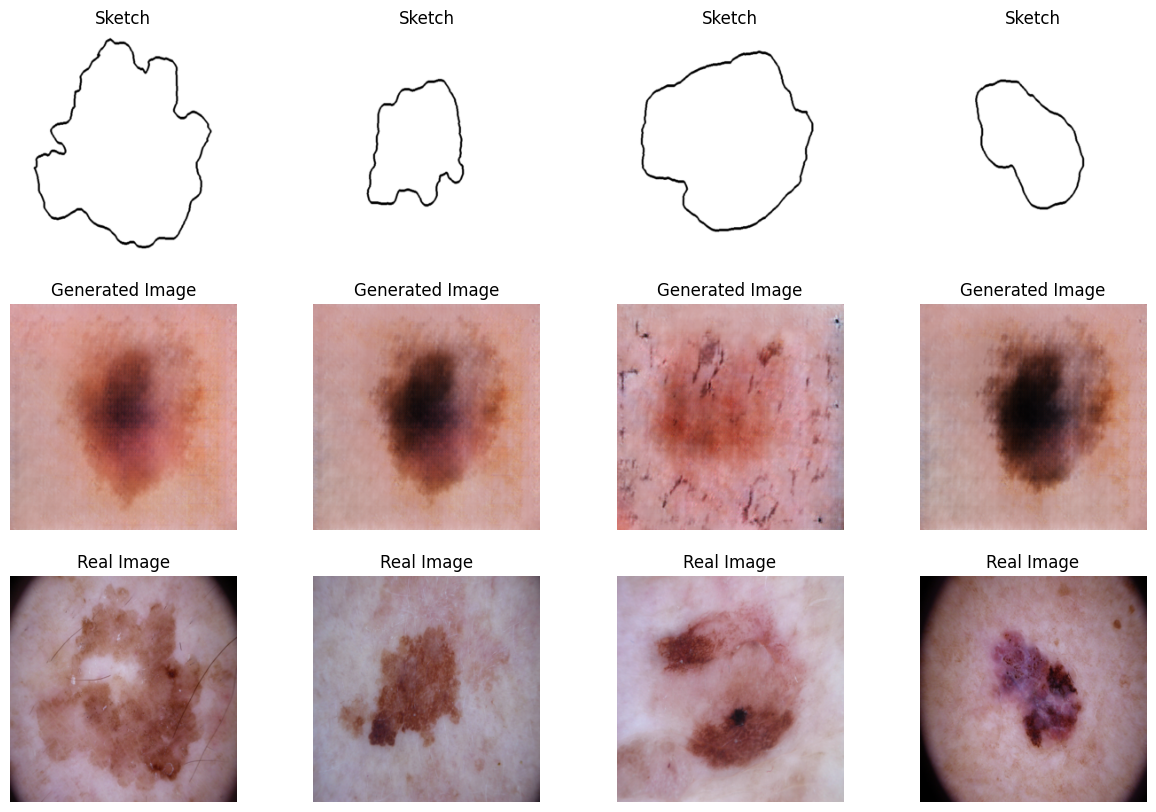

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/temp_generated_images" with extensions png,jpg,jpeg
Found 1000 samples
                                                                             

Inception Score: 1.9906132239342587


Processing samples
Inception Score: 1.9906132239342587 ± 0.03455117768448623


In [ ]:
import os
import torch
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics
from torchvision import transforms

generator.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs('temp_real_images', exist_ok=True)
os.makedirs('temp_generated_images', exist_ok=True)

def save_temp_images(batch_images, batch_indices, folder):
    for i, img in enumerate(batch_images):
        img_path = f'{folder}/img_{batch_indices[i]}.png'
        save_image(img, img_path, normalize=True)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        sketches = data['sketch'].to(device)
        real_images = data['image'].to(device)
        labels = data['label'].to(device)

        generated_images = generator(sketches, labels)

        batch_indices = range(i * test_loader.batch_size, (i + 1) * test_loader.batch_size)
        save_temp_images(real_images.cpu(), batch_indices, 'temp_real_images')
        save_temp_images(generated_images.cpu(), batch_indices, 'temp_generated_images')

        if i == 0:
            fig, axs = plt.subplots(3, len(sketches), figsize=(15, 10))
            for idx in range(len(sketches)):
                axs[0, idx].imshow(sketches[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, idx].set_title('Sketch')
                axs[0, idx].axis('off')

                axs[1, idx].imshow(generated_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, idx].set_title('Generated Image')
                axs[1, idx].axis('off')

                axs[2, idx].imshow(real_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[2, idx].set_title('Real Image')
                axs[2, idx].axis('off')

            plt.show()
inception_score = calculate_metrics(
    input1="/kaggle/working/temp_generated_images",
    isc=True,
    verbose=True
)

print(f'Inception Score: {inception_score["inception_score_mean"]}')


In [ ]:
import shutil

shutil.rmtree('temp_real_images')
shutil.rmtree('temp_generated_images')

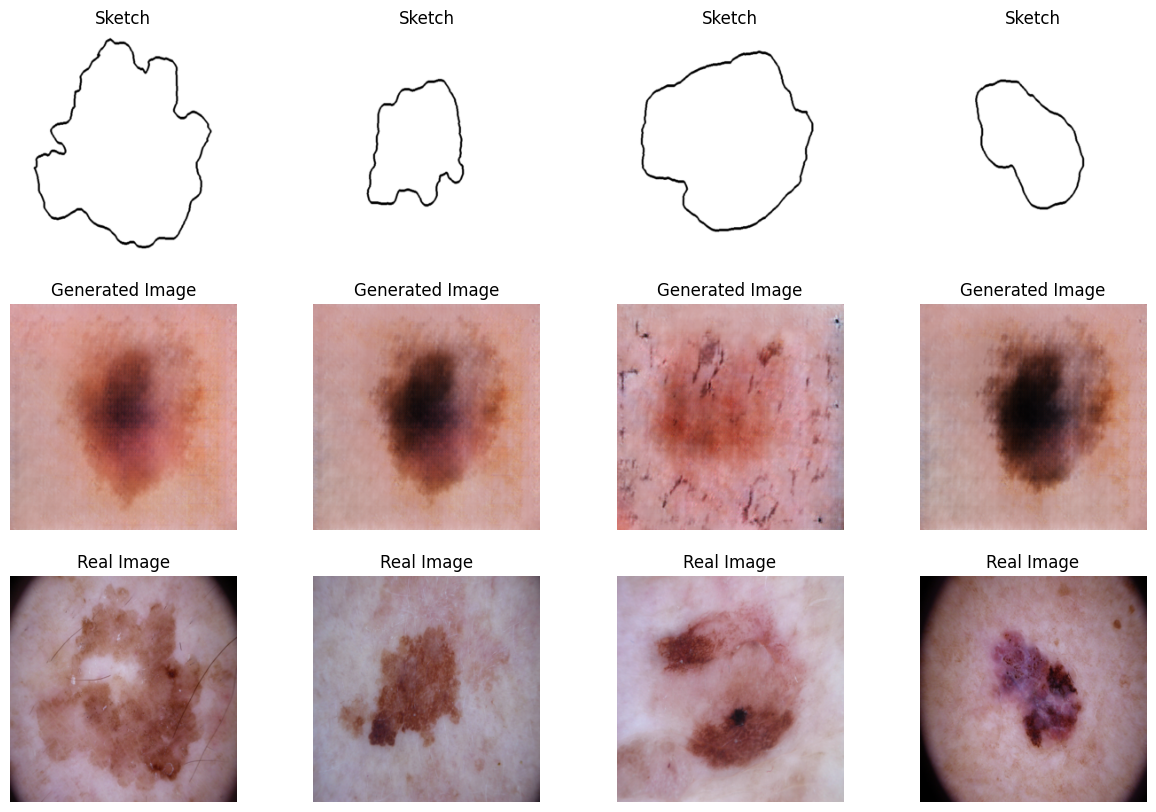

In [ ]:
def save_temp_images(batch_images, labels, folder_base):
    for img, label_tensor in zip(batch_images, labels):
        label = label_tensor.argmax().item()
        class_folder = f"{folder_base}/{label}"
        os.makedirs(class_folder, exist_ok=True)
        img_path = os.path.join(class_folder, f'img_{label}_{torch.randint(0, 10000, (1,)).item()}.png')
        save_image(img, img_path, normalize=True)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        sketches = data['sketch'].to(device)
        real_images = data['image'].to(device)
        labels = data['label'].to(device)

        generated_images = generator(sketches, labels)

        save_temp_images(real_images.cpu(), labels.cpu(), 'temp_real_images')
        save_temp_images(generated_images.cpu(), labels.cpu(), 'temp_generated_images')

        if i == 0:
            fig, axs = plt.subplots(3, len(sketches), figsize=(15, 10))
            for idx in range(len(sketches)):
                axs[0, idx].imshow(sketches[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, idx].set_title('Sketch')
                axs[0, idx].axis('off')

                axs[1, idx].imshow(generated_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, idx].set_title('Generated Image')
                axs[1, idx].axis('off')

                axs[2, idx].imshow(real_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[2, idx].set_title('Real Image')
                axs[2, idx].axis('off')

            plt.show()


In [ ]:
import os
import torch
import numpy as np
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from scipy.linalg import sqrtm
from torchvision.utils import save_image
import matplotlib.pyplot as plt

def load_inception_v3():
    model = models.inception_v3(pretrained=True, init_weights=False, transform_input=False)
    model.fc = torch.nn.Identity()
    model.eval()
    model.to(device)
    return model

inception_model = load_inception_v3()

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_dataloader(directory):
    dataset = datasets.ImageFolder(root=directory, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    return loader

def get_features(model, dataloader):
    features = []
    with torch.no_grad():
        for batch in dataloader:
            images, _ = batch
            images = images.to(device)
            output = model(images)
            features.append(output.detach().cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

def calculate_fid(mu1, sigma1, mu2, sigma2):
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0]
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    print(np.trace(sigma1 + sigma2 - 2 * covmean))
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

real_loader = get_dataloader("/kaggle/working/temp_real_images")
generated_loader = get_dataloader("/kaggle/working/temp_generated_images")

real_features = get_features(inception_model, real_loader)
generated_features = get_features(inception_model, generated_loader)

mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
mu_gen, sigma_gen = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

fid_value = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID Score:", fid_value)

-5.784976959332365e+61
FID Score: -5.784976959332365e+61


In [ ]:
shutil.rmtree('temp_real_images')
shutil.rmtree('temp_generated_images')

## Inference

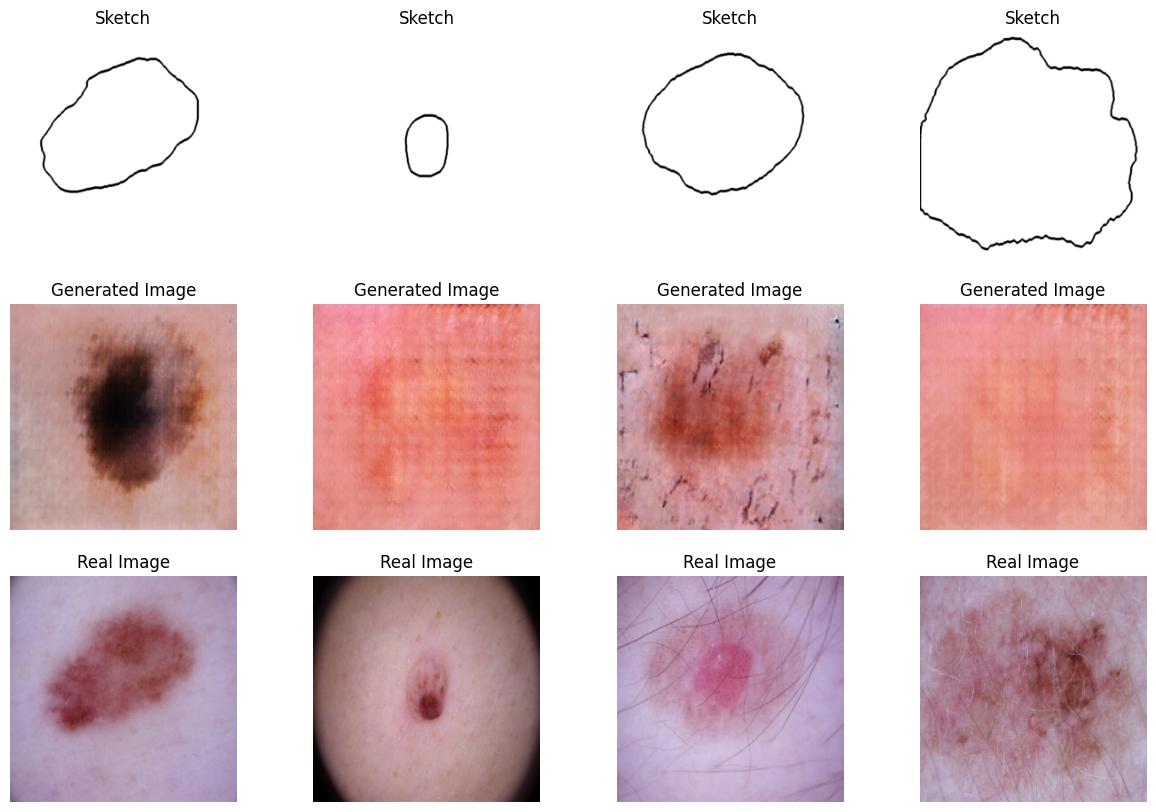

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        sketches = data['sketch'].to(device)
        real_images = data['image'].to(device)
        labels = data['label'].to(device)

        generated_images = generator(sketches, labels)
        if i == 0:
            fig, axs = plt.subplots(3, len(sketches), figsize=(15, 10))
            for idx in range(len(sketches)):
                axs[0, idx].imshow(sketches[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, idx].set_title('Sketch')
                axs[0, idx].axis('off')

                axs[1, idx].imshow(generated_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, idx].set_title('Generated Image')
                axs[1, idx].axis('off')

                axs[2, idx].imshow(real_images[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[2, idx].set_title('Real Image')
                axs[2, idx].axis('off')

            plt.show()

## Classifier


In [ ]:
!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #64
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#16
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#2
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 1 * 1, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 7)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

classifier = Classifier().to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 20

from torchsummary import summary

summary(classifier, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]           2,432
              ReLU-2         [-1, 32, 127, 127]               0
         MaxPool2d-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 31, 31]          51,264
              ReLU-5           [-1, 64, 31, 31]               0
         MaxPool2d-6           [-1, 64, 15, 15]               0
            Conv2d-7            [-1, 128, 7, 7]         204,928
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 3, 3]               0
           Conv2d-10            [-1, 256, 3, 3]         295,168
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Linear-13                   [-1, 64]          16,448
             ReLU-14                   

In [ ]:
from tqdm import tqdm

print(device)

for epoch in tqdm(range(num_epochs)):
    classifier.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, sample in enumerate(train_loader):
        real_images = sample['image'].to(device)
        labels = sample['label'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(real_images)
        loss = criterion(outputs, torch.max(labels, 1)[1])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == torch.max(labels, 1)[1]).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    if epoch == 2:
        torch.save(classifier.state_dict(),'test_weights.pth')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

torch.save(classifier.state_dict(), 'CNN_classifier_weights.pth')

## Model load

In [ ]:
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('/kaggle/input/cnn_classifier/pytorch/1/1/CNN_classifier_weights.pth'))

<All keys matched successfully>

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

generated_dataset = datasets.ImageFolder(root='/kaggle/working/temp_generated_images', transform=transform)
generated_loader = DataLoader(generated_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Number of classes: {len(generated_dataset.classes)}")
print(f"Class to index mapping: {generated_dataset.class_to_idx}")


In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        sketches = data['sketch'].to(device)
        real_images = data['image'].to(device)
        labels = data['label'].to(device)
        generated_images = generator(sketches, labels)



In [ ]:
import torch

generator.eval()
classifier.eval()

results = []
total_correct_predictions = 0
total_images_processed = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        sketches = data['sketch'].to(device)
        real_images = data['image'].to(device)
        labels = data['label'].to(device)

        generated_images = generator(sketches, labels)

        classification_outputs = classifier(generated_images)

        predicted_probabilities = torch.nn.functional.softmax(classification_outputs, dim=1)
        predicted_classes = predicted_probabilities.argmax(dim=1)
        actual_classes = labels.argmax(dim=1)

        correct_predictions = (predicted_classes == actual_classes).sum().item()
        total_images = labels.size(0)
        accuracy = correct_predictions / total_images

        total_correct_predictions += correct_predictions
        total_images_processed += total_images

        results.append({
            'batch': i,
            'accuracy': accuracy,
            'predicted_classes': predicted_classes.cpu().numpy(),
            'actual_classes': actual_classes.cpu().numpy()
        })

average_accuracy = total_correct_predictions / total_images_processed if total_images_processed else 0
print(f"Average Accuracy across all batches: {average_accuracy:.4f}")




Average Accuracy across all batches: 0.4060


## Test dataset

In [ ]:
import torch

generator.eval()
classifier.eval()

results = []
total_correct_predictions = 0
total_images_processed = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        sketches = data['sketch'].to(device)
        real_images = data['image'].to(device)
        labels = data['label'].to(device)


        classification_outputs = classifier(real_images)

        predicted_probabilities = torch.nn.functional.softmax(classification_outputs, dim=1)
        predicted_classes = predicted_probabilities.argmax(dim=1)
        actual_classes = labels.argmax(dim=1)

        correct_predictions = (predicted_classes == actual_classes).sum().item()
        total_images = labels.size(0)
        accuracy = correct_predictions / total_images

        total_correct_predictions += correct_predictions
        total_images_processed += total_images

        results.append({
            'batch': i,
            'accuracy': accuracy,
            'predicted_classes': predicted_classes.cpu().numpy(),
            'actual_classes': actual_classes.cpu().numpy()
        })

average_accuracy = total_correct_predictions / total_images_processed if total_images_processed else 0
print(f"Average Accuracy across all batches: {average_accuracy:.4f}")




Average Accuracy across all batches: 0.5630


In [ ]:
print(f"Accuracy for batch 0: {results[1]['accuracy']}")
print(f"Predicted classes: {results[1]['predicted_classes']}")
print(f"Actual classes: {results[1]['actual_classes']}")


Accuracy for batch 0: 0.75
Predicted classes: tensor([0, 1, 1, 0], device='cuda:0')
Actual classes: tensor([0, 1, 1, 1], device='cuda:0')


In [ ]:
import torch
import numpy as np
from torchvision import models, transforms
from torch.utils.data import DataLoader
from scipy.linalg import sqrtm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_inception_v3():
    model = models.inception_v3(pretrained=True, init_weights=False, transform_input=False)
    model.fc = torch.nn.Identity()
    model.eval()
    model.to(device)
    return model

inception_model = load_inception_v3()

generator.eval()
def get_features_and_generate_images(model, generator, dataloader):
    real_features = []
    generated_features = []
    with torch.no_grad():
        for data in dataloader:
            sketches = data['sketch'].to(device)
            labels = data['label'].to(device)
            real_images = data['image'].to(device)

            generated_images = generator(sketches, labels)

            real_output = model(real_images)
            generated_output = model(generated_images)

            real_features.append(real_output.cpu().numpy())
            generated_features.append(generated_output.cpu().numpy())

    real_features = np.concatenate(real_features, axis=0)
    generated_features = np.concatenate(generated_features, axis=0)
    return real_features, generated_features

real_features, generated_features = get_features_and_generate_images(inception_model, generator, test_loader)

mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
mu_gen, sigma_gen = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

fid_value = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID Score:", fid_value)